Inspired by Polylog youtube video discussing how to reveal you solved a sudoku puzzle without revealing the solution.
Discusses graph theory and coloring. Inspired me to code it and make a few coloring algorithms to solve.
Here is the video: https://youtu.be/Otvcbw6k4eo?si=d492EJsXopvabkxq 

How to use:
Change numColors to your grid size. The grid size should be a perfect square. For example, 4, 9, 16, 25 works. The higher up, the more complex and longer compute times.
Change solved to the initial state of your board. The top right square starts at zero. For example, if the initial state has a 1 in the first square, add (0,1) to the array. Repeat for all squares.
After those changes, run everything and a graph and completed board will be created. Note that it will run both algorithms, and the greedy will most likely fail

In [1]:
#Imports
import networkx as nx
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import numpy as np
import time
import copy


In [ ]:
#Change code here
numColors = 9
solved = [(0,1),(3,7),(5,8),
          (16,9),
          (18,9),(20,3),(24,6),(25,2),(26,8),
          (27,3),(31,7),(33,8),(35,9),
          (39,4),(40,8),
          (45,8),(46,5),(47,7),(48,6),(49,3),(50,9),
          (60,1),(62,5),(63,7),
          (65,1),(66,8),(68,6),(71,4),
          (76,1),(79,8)]

In [3]:
#Creates a graph for sodoku puzzle
def new_sodoku(k, solved):
    if k < 0:
        print("Negative numbers cannot be squares")
        return False
    root = int(math.sqrt(k))
    if (root*root != k):
        print("Number chosen is not a perfect square")

    G = nx.Graph()
    num_vertices = k*(k+1)
    G.add_nodes_from(range(num_vertices))

    boxes = []
    for x in range(root):
        boxes.append([])
        for y in range(root):
            boxes[x].append([])
    
    for x in range(k*k):
        xrow = x % k
        for y in range(1,k-xrow):
            G.add_edge(x, x+y)

        xcol = x // k
        for y in range(1,k-xcol):
            G.add_edge(x, x + k * y)

        xboxV = (x % k) // root
        xboxH = (x // k) // root
        boxes[xboxV][xboxH].append(x)

    for x in range(len(boxes)):
        for y in range(len(boxes[x])):
            for i in range(len(boxes[x][y])):
                for j in range(i+1, len(boxes[x][y])):
                    G.add_edge(boxes[x][y][i],boxes[x][y][j])

    for i in range((k*k), (k*k + k)):
        for j in range(i + 1, (k*k + k)):
            G.add_edge(i,j)

    colors = ['lightblue'] * (k * k)
    cmap = plt.get_cmap('tab10')

    for j in range(k):
        color = cmap(j % cmap.N)
        colors.append(color)

    for x,n in solved:
        for y in range(1,k+1):
            c = k*k + (y-1)
            if(y != n):
                G.add_edge(x,c)
            else:
                colors[x] = colors[c]

    return G, colors

In [4]:
#Greedy Graph Coloring Algorithm
def greedy_sudoku_solver(G, colors, k):
    
    node_colors = {i: colors[i] for i in range(len(colors))}
    digit_nodes = list(range(k*k, k*k + k))
    digit_colors = [node_colors[d] for d in digit_nodes]
    uncolored = {i for i in range(k*k) if node_colors[i] == 'lightblue'}

    while uncolored:
        max_node = max(uncolored, key=lambda n: sum(
            1 for neighbor in G.neighbors(n)
            if node_colors[neighbor] != 'lightblue'
        ))

        neighbor_colors = {node_colors[nbr] for nbr in G.neighbors(max_node) if node_colors[nbr] != 'lightblue'}

        for color in digit_colors:
            if color not in neighbor_colors:
                node_colors[max_node] = color
                break

        uncolored.remove(max_node)

    for i in range(len(colors)):
        colors[i] = node_colors[i]

    return G, colors

In [5]:
#WFC Algorithm
def wfc_sudoku_solver(G, k, colors):
    digits = set(colors[k * k:])
    domains = {node: set(digits) for node in range(k * k) if colors[node] == 'lightblue'}
    
    for node in range(k * k):
        if colors[node] != 'lightblue':
            for neighbor in G.neighbors(node):
                if neighbor in domains:
                    domains[neighbor].discard(colors[node])

    def select_most_constrained():
        return min(domains, key=lambda n: len(domains[n]))

    def forward_check(node, color):
        removed = {}
        for neighbor in G.neighbors(node):
            if neighbor in domains and color in domains[neighbor]:
                domains[neighbor].remove(color)
                if neighbor not in removed:
                    removed[neighbor] = set()
                removed[neighbor].add(color)
                if not domains[neighbor]:
                    return False, removed
        return True, removed

    def restore_domains(removed):
        for n, colors_removed in removed.items():
            domains[n].update(colors_removed)

    def backtrack():
        if not domains:
            return True

        node = select_most_constrained()
        for color in list(domains[node]):
            colors[node] = color
            local_domain = domains.pop(node)

            valid, removed = forward_check(node, color)
            if valid:
                if backtrack():
                    return True
            restore_domains(removed)
            domains[node] = local_domain
            colors[node] = 'lightblue'

        return False

    if not backtrack():
        raise Exception("No solution found.")

    return G, colors



In [6]:
def draw_sudoku_graph(G, colors, k):
    pos = {}
    for i in range(k * k):
        row = i // k
        col = i % k
        pos[i] = (col, -row)

    side_col_x = k + 1
    for j in range(k):
        node_id = k * k + j
        pos[node_id] = (side_col_x, -j)

    labels = {k * k + j: f"{j+1}" for j in range(k)}
    labels.update({i: str(i) for i in range(k * k)})

    nx.draw(G, pos=pos, with_labels=True, node_color=colors, edge_color='gray',
            arrows=True, connectionstyle="arc3,rad=0.1", labels=labels)

    plt.axis('off')
    plt.show()

In [7]:
def draw_sudoku_board(colors, k):
    board = np.full((k, k), '', dtype=object)
    digit_colors = colors[k*k:]

    color_to_digit = {color: str(i + 1) for i, color in enumerate(digit_colors)}

    for i in range(k * k):
        row = i // k
        col = i % k
        cell_color = colors[i]
        board[row, col] = color_to_digit.get(cell_color, '')

    fig, ax = plt.subplots(figsize=(k/2, k/2))
    ax.axis('off')

    for i in range(k):
        for j in range(k):
            ax.text(j + 0.5, k - i - 0.5, board[i, j], va='center', ha='center', fontsize=16)
            ax.add_patch(plt.Rectangle((j, k - i - 1), 1, 1, fill=False, edgecolor='black'))

    root = int(k ** 0.5)
    for i in range(0, k + 1, root):
        lw = 2
        ax.plot([0, k], [i, i], color='black', linewidth=lw)
        ax.plot([i, i], [0, k], color='black', linewidth=lw)

    ax.set_xlim(0, k)
    ax.set_ylim(0, k)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

Time for graph creation: 0.0045702457427978516 seconds


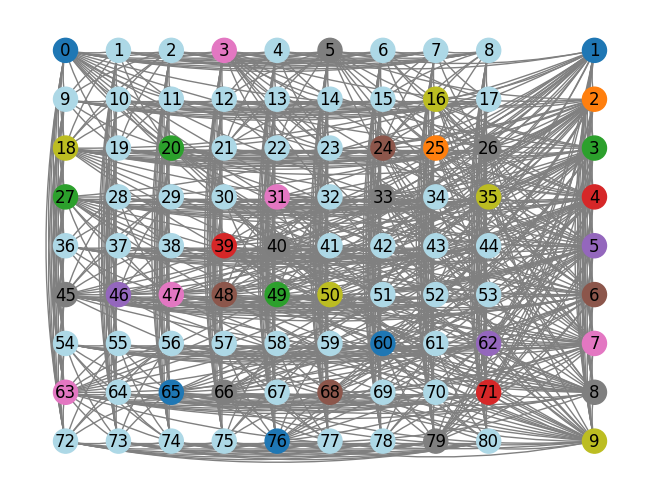

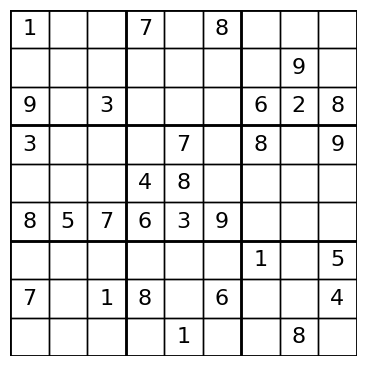

Time for draw graph: 3.513169527053833 seconds
Time for greedy algorithm: 0.003396749496459961 seconds


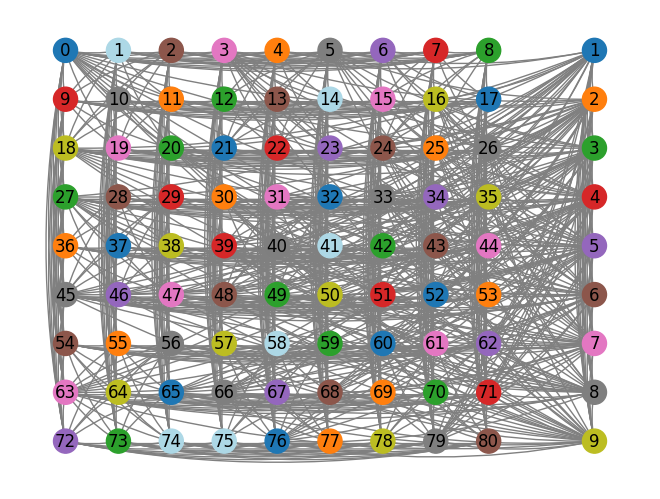

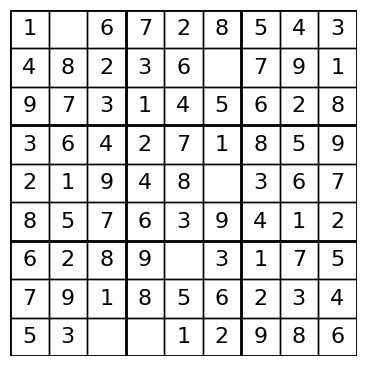

Time for WFC algorithm: 0.0010042190551757812 seconds


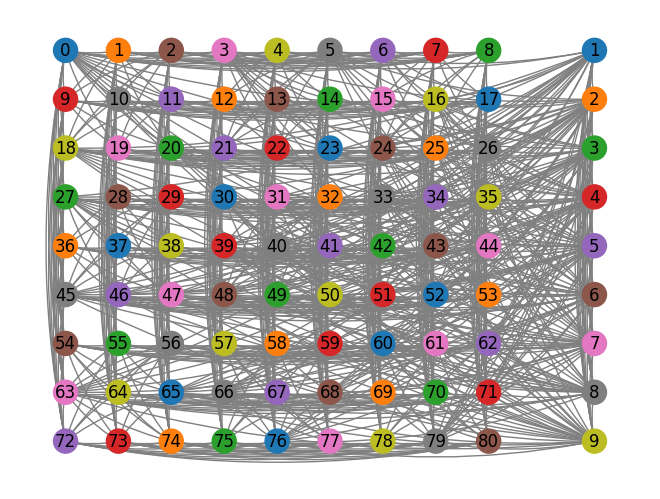

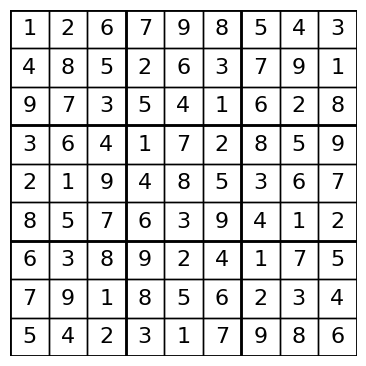

In [8]:
#Creating graph and edges
graph_start = time.time()
G, colors = new_sodoku(numColors, solved)
graph_end = time.time()
graph_elasped = graph_end - graph_start
print(f"Time for graph creation: {graph_elasped} seconds")

#Drawing unsolved graph
draw_start = time.time()
draw_sudoku_graph(G,colors,numColors)
draw_sudoku_board(colors, numColors)
draw_end = time.time()
draw_elasped = draw_end - draw_start
print(f"Time for draw graph: {draw_elasped} seconds")

#Solve using greedy then draw
greedy_G = G.copy()
greedy_colors = copy.deepcopy(colors)
greedy_start = time.time()
greedy_G, greedy_colors = greedy_sudoku_solver(greedy_G, greedy_colors, numColors)
greedy_end = time.time()
greedy_elasped = greedy_end - greedy_start
print(f"Time for greedy algorithm: {greedy_elasped} seconds")
draw_sudoku_graph(greedy_G,greedy_colors,numColors)
draw_sudoku_board(greedy_colors, numColors)

#Solve using wfc then draw
wfc_G = G.copy()
wfc_colors = copy.deepcopy(colors)
wfc_start = time.time()
wfc_G, wfc_colors = wfc_sudoku_solver(wfc_G, numColors, wfc_colors)
wfc_end = time.time()
wfc_elasped = wfc_end - wfc_start
print(f"Time for WFC algorithm: {wfc_elasped} seconds")
draw_sudoku_graph(wfc_G,wfc_colors,numColors)
draw_sudoku_board(wfc_colors, numColors)